In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
bike_rentals=pd.read_csv('bike_rental_hour.csv')

In [23]:
bike_rentals.head(3)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


In [24]:
bike_rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

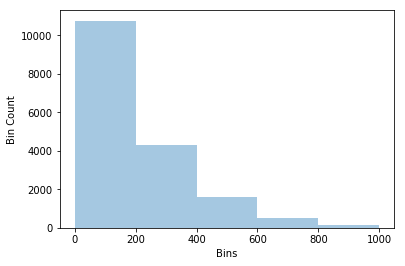

In [25]:
sns.distplot(bike_rentals['cnt'],kde=False,bins=[0,200,400,600,800,1000])
plt.xlabel('Bins')
plt.ylabel('Bin Count')
plt.show()

In [26]:
#get corr matrix and filter df for 'cnt' column
bike_rentals.corr()['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
casual        0.694564
registered    0.972151
cnt           1.000000
Name: cnt, dtype: float64

In [27]:
def assign_label(hour):
    if (6 <= hour) and (hour < 12):
        return 1
    if (12 <= hour) and (hour < 18):
        return 2
    if (18 <= hour) and (hour < 24):
        return 3
    if (0 <= hour) and (hour < 6):
        return 4

bike_rentals['time_label']=bike_rentals['hr'].apply(assign_label)
    

In [28]:
#crosstab exploration - use .T to transpose rows and cols
pd.crosstab(bike_rentals['cnt'],bike_rentals['time_label'] , margins=True).T

cnt,1,2,3,4,5,6,7,8,9,10,...,948,953,957,963,967,968,970,976,977,All
time_label,,,,,,,,,,,,,,,,,,,,,
1,8,16,9,11,11,10,11,11,7,21,...,0,0,0,0,0,0,0,0,0,4360
2,0,0,1,0,0,0,1,0,0,1,...,1,1,1,1,1,0,1,1,0,4375
3,0,1,0,1,0,2,1,1,3,2,...,0,0,0,0,0,1,0,0,1,4368
4,150,191,214,219,249,224,185,170,118,131,...,0,0,0,0,0,0,0,0,0,4276
All,158,208,224,231,260,236,198,182,128,155,...,1,1,1,1,1,1,1,1,1,17379


In [29]:
#Picking MAE and RMSE as error metrics because the cnt is continuous
#MAE is intuitive; RMSE is sensitive to outliers.

In [30]:
shuffled=bike_rentals.sample(frac=1,random_state=1)
eighty_pct=int(round(shuffled.shape[0]*.8,0))
train=shuffled.iloc[:eighty_pct]
test=shuffled.iloc[eighty_pct:]
#test=shuffled.loc[~shuffled.index.isin(train.index)]

In [31]:
print('Count of train indices in test:', test.index.isin(train.index).sum())
print('Count of test indices in train:',train.index.isin(test.index).sum())

Count of train indices in test: 0
Count of test indices in train: 0


In [32]:
#feature list - exclude holiday, weekday, workingday?
cols=['instant', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',\
      'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',\
      'time_label']
#cols.remove('windspeed') #worsens forest mse but not mae

#LR: instantiate lr, fit, and predict
lr=LinearRegression()
lr.fit(train[cols],train['cnt'])
train_pred=lr.predict(train[cols])
test_pred=lr.predict(test[cols])

mae_train=mean_absolute_error(train['cnt'],train_pred)
mae_test=mean_absolute_error(test['cnt'],test_pred)
mse_test=mean_squared_error(test['cnt'],test_pred)
print('mae train:',round(mae_train,2))
print('mae test:',round(mae_test,2))
print('Test minus Train Overfit?:',round(mae_test-mae_train,2))
print('MSE:',mse_test)

mae train: 99.68
mae test: 98.43
Test minus Train Overfit?: -1.26
MSE: 17052.1248712


In [33]:
#The lr prediction is not bad.  But, there are non-linearities,
#due to the bucketing of information, like weather.
#Therefore, a model like random forest is better.

#Feature engineering.  Added time_label derived from hr.
#If hr is removed, error shoots up, so overweighting helps.

In [34]:
#Decision Tree: instantiate lr, fit, and predict
for min_samp_lf in [1,2,4,6,8,16,32]:
    clf=DecisionTreeRegressor(min_samples_leaf=min_samp_lf)
    clf.fit(train[cols],train['cnt'])
    train_clf_predict=clf.predict(train[cols])
    test_clf_predict=clf.predict(test[cols])
    mae_train_tree=mean_absolute_error(train['cnt'],train_clf_predict)
    mae_test_tree=mean_absolute_error(test['cnt'],test_clf_predict)
    mse_test_tree=mean_squared_error(test['cnt'],test_clf_predict)
    print('min_samples_leaf=',min_samp_lf)
    print('mae train tree:',round(mae_train_tree,2))
    print('mae test tree:',round(mae_test_tree,2))
    print('Test minus Train Overfit?:',round(mae_test_tree-mae_train_tree,2))
    print('MSE:',round(mse_test_tree,2))
    print('**********')

min_samples_leaf= 1
mae train tree: 0.0
mae test tree: 32.62
Test minus Train Overfit?: 32.62
MSE: 3080.25
**********
min_samples_leaf= 2
mae train tree: 9.29
mae test tree: 32.52
Test minus Train Overfit?: 23.23
MSE: 2961.77
**********
min_samples_leaf= 4
mae train tree: 16.76
mae test tree: 31.05
Test minus Train Overfit?: 14.29
MSE: 2790.26
**********
min_samples_leaf= 6
mae train tree: 20.09
mae test tree: 30.7
Test minus Train Overfit?: 10.61
MSE: 2632.17
**********
min_samples_leaf= 8
mae train tree: 22.29
mae test tree: 31.14
Test minus Train Overfit?: 8.85
MSE: 2660.92
**********
min_samples_leaf= 16
mae train tree: 27.07
mae test tree: 32.91
Test minus Train Overfit?: 5.84
MSE: 2960.86
**********
min_samples_leaf= 32
mae train tree: 31.91
mae test tree: 35.34
Test minus Train Overfit?: 3.43
MSE: 3312.65
**********


In [35]:
#Changing min_samples_leaf to 32 gets the cnt mean abs error
#down to 35-36 with low overfit.

In [36]:
#Random Forest: instantiate lr, fit, and predict
for min_samp_lf in [1,2,4,6,8,16,32]:
    forest=RandomForestRegressor(n_estimators=50,min_samples_leaf=min_samp_lf)
    forest.fit(train[cols],train['cnt'])
    train_forest_predict=forest.predict(train[cols])
    test_forest_predict=forest.predict(test[cols])
    mae_train_forest=mean_absolute_error(train['cnt'],train_forest_predict)
    mae_test_forest=mean_absolute_error(test['cnt'],test_forest_predict)
    mse_test_forest=mean_squared_error(test['cnt'],test_forest_predict)
    print('min_samples_leaf=',min_samp_lf)
    print('mae train forest:',round(mae_train_forest,2))
    print('mae test forest:',round(mae_test_forest,2))
    print('Test minus Train Overfit?:',round(mae_test_forest-mae_train_forest,2))
    print('MSE:',round(mse_test_forest,2))
    print('**********')

min_samples_leaf= 1
mae train forest: 9.11
mae test forest: 25.33
Test minus Train Overfit?: 16.22
MSE: 1853.09
**********
min_samples_leaf= 2
mae train forest: 11.99
mae test forest: 25.64
Test minus Train Overfit?: 13.65
MSE: 1859.71
**********
min_samples_leaf= 4
mae train forest: 16.88
mae test forest: 26.5
Test minus Train Overfit?: 9.63
MSE: 1979.01
**********
min_samples_leaf= 6
mae train forest: 19.61
mae test forest: 27.24
Test minus Train Overfit?: 7.63
MSE: 2089.82
**********
min_samples_leaf= 8
mae train forest: 21.8
mae test forest: 28.01
Test minus Train Overfit?: 6.22
MSE: 2209.63
**********
min_samples_leaf= 16
mae train forest: 26.73
mae test forest: 31.07
Test minus Train Overfit?: 4.34
MSE: 2665.9
**********
min_samples_leaf= 32
mae train forest: 32.7
mae test forest: 35.46
Test minus Train Overfit?: 2.75
MSE: 3268.48
**********


In [37]:
#Increased number of trees (number of estimators) from 10 to 50.
#At min_samples_leaf=16, this improved mae test and reduced overfit.

In [38]:
#Dropping 'windspeed' feature slightly increases forest overfit
#and slightly improves 'mae test forest' at min_samples_leaf = 32.
#But MSE gets worse.

#In general, when features (Ex. windspeed) are removed, mse 
#goes up and model generalization goes down.